In [1]:
# Import aller benötigten Module

# Eigene Module
import DataGenerationRadar1D as gen_1D
from DataGenerationRadar3D import *
from DBScan import *
from KalmanFilter import KalmanFilter
from ui import interactive1DExperiment, interactiveDBScan, interactive3DExperiment

# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import *
from collections import deque
%matplotlib widget
plt.style.use('classic')

# Projektlabor Maschinelles Lernen (PML)
**Präsentation: Gruppe 7**\
\
Domenic Gosein, Lukas Burger, Maximilian Kürschner, Christian Singer\
\
25.02.2022\
Informationstechnik\
\
<img src="hsma_logo.png" alt="logo" width="400"/>

## Agenda
1. Einleitung 
    1. Der 𝛼-𝛽 Filter und Kalman Gain
2. Das Kalman-Filter 
    1. dynamische H-Matrix
    2. MSE (Metrik) und was wir damit erreicht haben
    3. Transitionsmodell, R-  und Q-Matrix
    4. Interaktiver Plot 1D Experiment
3. 3D Radarsensor Experiment
    1. Kalman-Filter ohne DB-Scan
    2. Kalman-Filter mit DB-Scan (und MSE Metrik)
4. Schlussfolgerung & Ausblick (Radialgeschwindigkeit)

## Theorie: Kalman-Gain und a-b-Filter
- a-b Filter ist simpelste Art von Filter. 
- Das Verhältnis, in dem Messung und Modell zur Vorhersage beitragen, ist beim a-b-Filter fix.
- Beim Kalman Filter wird diese Gewichtung dynamisch durch Kalman-Gain bestimmt.

## Praxis: Dynamische Auswahl der H-Matrix
- Problem:  Eventuell nicht immer alle Sensormessungen verfügbar.
- Lösung:   Statte Filter mit von der Messung abhängigen Versionen der H Matrix aus.
- Beispiel: Filter bekommt entweder nur Position oder auch Geschwindigkeit als extra Input.

## Theorie: Mean Squared Error (MSE)
- MSE ist eine Metrik zur Messung der Distanz zwischen zwei Pfaden
$$
MSE = \frac{1}{n}\sum_{i=1}^n(Y_{i}-\hat{Y}_{i})^2
$$
- Ermöglicht quantitativen Vergleich von Vorhersage und eigentlichem Pfad.

## Theorie: R-Matrix
- Messfehler sind uniform verteilt.
- R-Matrix beschreibt die Varianz der Sensormessungen.
- Die Varianz einer uniform verteilten Zufallsvariable beträgt
$$
\frac{1}{12}(b-a)^2
$$
- Daher kann R auch mit theoretischer Begründung gewählt werden.

## Theorie: Q-Matrix:

- Beinhaltet unmodellierte Dynamiken und Parameterunsicherheiten
- $Q$-Matrix von null verschiedenen $\rightarrow$ Bessere Konvergenzeigenschaften
- Hohes $Q$ $\rightarrow$ Verrauschten Messungen werden höher gewichtet 
- Niedriges $Q$ $\rightarrow$ Bessere Schätzgenauigkeit

$\Rightarrow$ Systematische Anpassung der $Q$-Matrix

## Theorie: Transitionsmodell:

Berechnung folgt dem **Weg-Zeit Gesetz**
* Beschleunigung: $a = const$
* Geschwingkeits-Zeit-Gesetz: $v(t) = \dot{s}(t) = at + v_0$
* Weg-Zeit Gesetz: $s(t) = \frac{a}{2}t^2 + v_0t +s_0$

$$
\begin{aligned}
&\begin{array}{lll}
s[k]=s[k-1]+&v[k-1]*dt & +a[k-1]*\frac{1}{2}*dt^2 \\
v[k]=       &v[k-1]    & +a[k-1]*dt\\
a[k]=       &          & +a[k-1]*dt\\
\end{array}
\end{aligned}
$$


Die zeitliche Entwicklung des Zustandsvektors kann mit einem lineares
Gleichungssystem beschrieben werden. Dabei gilt $dt = \frac{1}{measurementRate}$.
```python
dt = 1 / gen_1D.measurementRate # default: measurementRate = 100 Hz
transition_model = np.array([[1, dt, dt**2/2],
                            [0,   1, dt  ],
                            [0,   0, dt ]])
```

## Praxis: 1D-Experiment

Output()

Output()

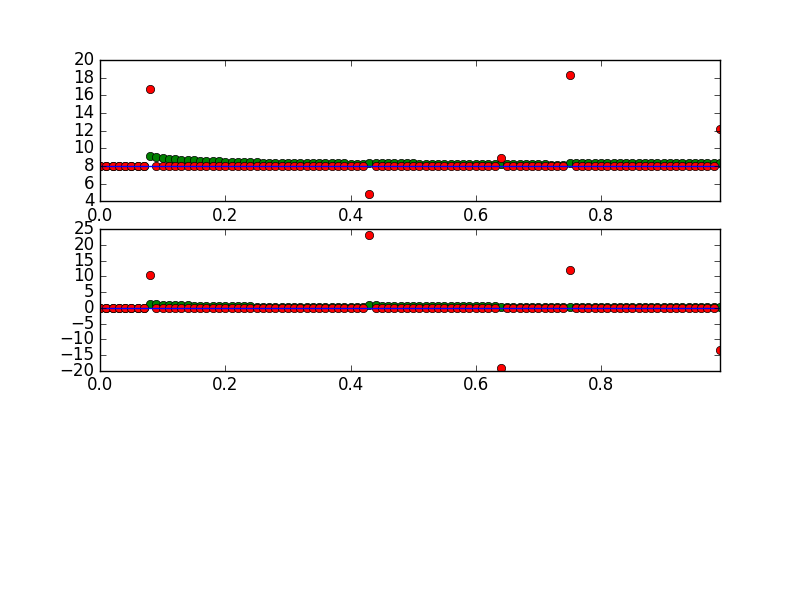

In [2]:
interactive1DExperiment.plot_interactive_kalaman_filter()

## Das Kalman-Filter ohne DBScan
### Theorie: Initialisierung

* Transitionsmodell:$$
                    \begin{pmatrix}
                    1 & 0.01 & 0.01/2 \\
                    0 & 1 & 0.01 \\
                    0 & 0 & 0.01 \\
                    \end{pmatrix}
                    $$  
* Q-Matrix:         $$
                    \begin{pmatrix}
                    0.5 & 0 & 0 \\
                    0 & 0.5 & 0 \\
                    0 & 0 & 0.5 \\
                    \end{pmatrix}
                    $$  
* R-Matrix:         $$
                    \frac{\sigma^2}{3}
                    $$  
* H-Matrix:         $$
                    \begin{pmatrix}
                    1 & 0 & 0 \\
                    \end{pmatrix}
                    $$

Domenic:
* Unser Transitionsmodell ist dem Skript entnommen, die Messrate haben wir allerdings auf 100 Hz angepasst, wie dies auch beim 1D Experiment der Fall war
* Für die Initialisierung der Q-Matrix wählen wir zunächst einen Wert von 0.02 (mehr dazu gleich)
* Die Herleitung der Werte für die R-Matrix wurde bereits erklärt und sieht wie folgt aus
* Zum Schluss die H-Matrix, in der wir nur unsere Anfangsposition berücksichtigen

### Praxis: Verschiedene Einstellungen der Parameter

In [3]:
def show_plot_slide():
    
    path = [[0,5,0],
        [0,5,0.5],
        [1,5,1],
        [1,5,0.5],
        [0.5, 2, 0.1]]

    vel = 3 * numpy.ones((1,5))
    vel[0,2] = 1

    InitialPosition = numpy.array([-1,5,0])

    opt = {
        'InitialPosition' : InitialPosition,
        'Path' : numpy.array(path).transpose(),
        'Velocities' : vel
    }

    x = Target(opt)

    targets = [x]

    # Initialisierung benötigter Variablen
    Detections = np.array([0,0,0,0])
    i = 0
    pred = []

    getNext = True
    while(getNext == True):

        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            Detections = np.vstack((det, Detections))

        s0 = np.vstack((Detections[0,:-1], np.zeros((2,3))))

        if i == 0:
            f = KalmanFilter(s0, transition_model, H, Q, R)
            pred.append(s0[0,:])

        s = Detections[0,:-1].reshape(1,3)
        s_hat = f.step(s)
        pred = np.vstack((s_hat[0,:], pred))
        i += 1

    T1 = pred[:-1]
    
    fig = plt.figure(figsize=(8, 4),facecolor='w')
    ax1 = fig.add_subplot(121, projection='3d')   
    ax2 = fig.add_subplot(122, projection='3d')
    ax1.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
    ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')
    
    fig = plt.figure(facecolor='w')
    ax = plt.axes(projection='3d')
    ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
    ax.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

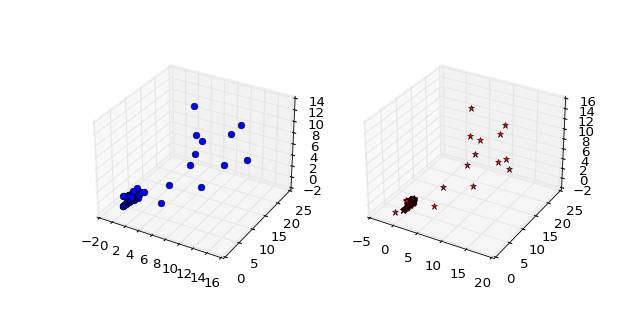

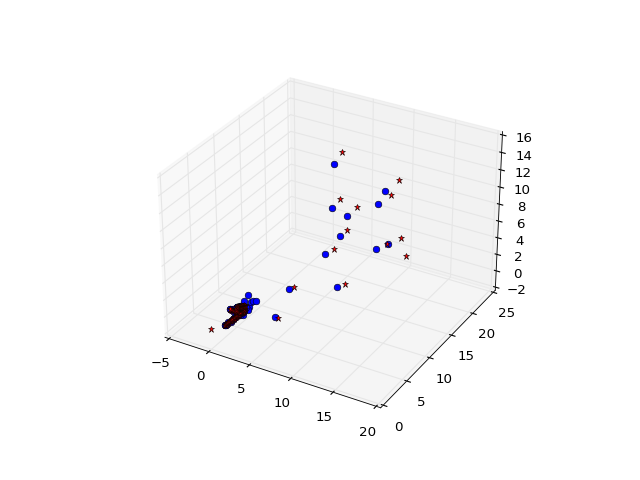

In [17]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
Q = np.diag([0.5, 0.5, 0.5])
#R = np.diag([rangeAccuracy**2])/3
R = np.diag([0.05])
H =  np.array([[1, 0, 0]])
optRadar = {
    'Position' : numpy.array([0,0,0.5]),
    'OpeningAngle' : numpy.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True,
    'falseDetectionsRange' : 10 # neuer Parameter für Range
}
sensor = RadarSensor(optRadar)
show_plot_slide()

Domenic:
* Führen wir nun das Experiment mit diesen Werten aus, sehen wir, dass das hohe Prozessrauschen dazu führt, dass bei Ausreißern die blauen Punkte des Kalman Filter sehr nahe an den Detections des Radarsensors liegen
* Die von uns gewählte Q-Matrix eignet sich also nicht besonders gut, da der Kalman Filter bei Ausreißern nicht nah am Pfad des Objekts bleibt
* Reduzieren wir also das Prozessrauschen auf einen Wert von 0.02 und erhöhen gleichzeitig die R-Matrix auf einen Wert von 0.05
* Nun sehen wir das die Vorhersagen des Kalman Filter deutlich näher am eigentlichen Pfad des Objekts liegen

## Praxis: Das Kalman-Filter mit DBScan

Output()

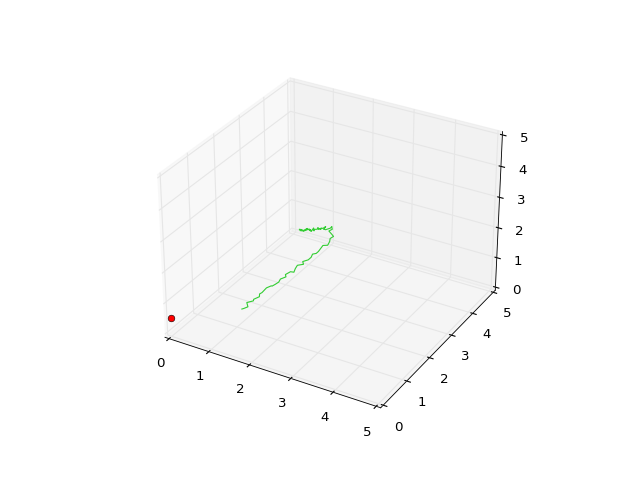

In [5]:
interactive3DExperiment.plot_3DExperiment()

### Schlussfolgerung

* Enmorme Verbesserungen im Vergleich zu reinen Sensordaten im 1D-Fall
* Verbesserungen bei steigendem Messfehler im 3D-Fall spürbar
* Sinvolle Positionsvorhersagen mittels DBScan

### Ausblick
* Einbinden von weiter zurückliegenden Observationen (smoothing)
* Verwendung von echten Sensordaten und Weiterentwicklung 

## Weiterführende Informationen & Ende
* tbd